In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [5]:
input_data_raw1 = np.loadtxt('input_data_save.txt')
cap_data_raw1 = np.loadtxt('cap_data_save.txt')

In [7]:
# Convert the training data to PyTorch tensors
x_train_tensor_raw = torch.tensor(input_data_raw1, dtype=torch.float32)
y_train_tensor_raw = torch.tensor(cap_data_raw1, dtype=torch.float32)

In [9]:
def normalize_tensor(tensor, max_val, min_val):
    return (tensor - min_val) / (max_val - min_val)

x_train_epsneg_raw1 = x_train_tensor_raw[:, 0]
x_train_epspos_raw1 = x_train_tensor_raw[:, 1]

max_epsneg = torch.max(x_train_epsneg_raw1)
min_epsneg = torch.min(x_train_epsneg_raw1)

max_epspos = torch.max(x_train_epspos_raw1)
min_epspos = torch.min(x_train_epspos_raw1)

x_train_epsneg_norm1 = normalize_tensor(x_train_epsneg_raw1, max_epsneg, min_epsneg)
x_train_epspos_norm1 = normalize_tensor(x_train_epspos_raw1, max_epspos, min_epspos)
x_train = torch.stack((x_train_epsneg_norm1, x_train_epspos_norm1), dim=1)

y_train_tensor = y_train_tensor_raw
max_y = torch.max(y_train_tensor)
min_y = torch.min(y_train_tensor)

y_train_norm = normalize_tensor(y_train_tensor, max_y, min_y)
y_train = y_train_norm.reshape(200,1)

In [11]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        # Define the layers
        self.layer1 = nn.Linear(2, 15)  # Input layer (2 inputs) to first hidden layer (15 neurons)
        self.layer2 = nn.Linear(15, 5)  # First hidden layer (15 neurons) to second hidden layer (5 neurons)
        self.layer3 = nn.Linear(5, 1)   # Second hidden layer (5 neurons) to output layer (1 output)
        
        # Define activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Forward pass through the network
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Instantiate the model
model = ANN()

# Define the loss function (Mean Squared Error for regression)
criterion = nn.MSELoss()

# Define the optimizer (Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=0.05)

In [13]:
# Number of epochs for training
num_epochs = 20000

for epoch in range(num_epochs):
    # Forward pass: compute the model output
    outputs = model(x_train)
    
    # Compute the loss
    loss = criterion(outputs, y_train)
    
    # Backward pass: compute the gradients
    optimizer.zero_grad()
    loss.backward()
    
    # Update the weights
    optimizer.step()
    
    # Print the loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/20000], Loss: 0.0660
Epoch [200/20000], Loss: 0.0547
Epoch [300/20000], Loss: 0.0454
Epoch [400/20000], Loss: 0.0399
Epoch [500/20000], Loss: 0.0369
Epoch [600/20000], Loss: 0.0348
Epoch [700/20000], Loss: 0.0330
Epoch [800/20000], Loss: 0.0314
Epoch [900/20000], Loss: 0.0297
Epoch [1000/20000], Loss: 0.0278
Epoch [1100/20000], Loss: 0.0257
Epoch [1200/20000], Loss: 0.0233
Epoch [1300/20000], Loss: 0.0206
Epoch [1400/20000], Loss: 0.0175
Epoch [1500/20000], Loss: 0.0143
Epoch [1600/20000], Loss: 0.0114
Epoch [1700/20000], Loss: 0.0090
Epoch [1800/20000], Loss: 0.0071
Epoch [1900/20000], Loss: 0.0057
Epoch [2000/20000], Loss: 0.0047
Epoch [2100/20000], Loss: 0.0041
Epoch [2200/20000], Loss: 0.0036
Epoch [2300/20000], Loss: 0.0032
Epoch [2400/20000], Loss: 0.0029
Epoch [2500/20000], Loss: 0.0026
Epoch [2600/20000], Loss: 0.0024
Epoch [2700/20000], Loss: 0.0021
Epoch [2800/20000], Loss: 0.0019
Epoch [2900/20000], Loss: 0.0018
Epoch [3000/20000], Loss: 0.0017
Epoch [3100/20000],

In [15]:
# Define the function to optimize
def objective_function(x):
    tensor1 = x[0]    # 1 represents the anode porosity 
    tensor2 = x[1]    # 2 represents the cathode porosity
    x_input = torch.stack((tensor1, tensor2), dim=0)
    return model(x_input)

# Initialize the inputs (parameters to optimize)
val0 = torch.rand(1)    # an initial guess of anode porosity (normalized)
val1 = torch.rand(1)    # an initial guess of cathode porosity (normalized)
x = torch.tensor([val0, val1], requires_grad=True)

# Define the optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD([x], lr=0.01)  # lr is the learning rate

# Number of optimization steps
num_steps = 100

# Lists to store the evolution of x[0], x[1], and loss
x0_values = []
x1_values = []

# Optimization loop
for step in range(num_steps):
    # Zero the gradients from the previous step
    optimizer.zero_grad()

    # Compute the objective function
    result = objective_function(x)
    loss = -result[0]

    # Compute the gradients (backward pass)
    loss.backward()

    # Update the parameters using the optimizer
    optimizer.step()

    # Apply the constraints to keep x[0] and x[1] within [0, 1]
    with torch.no_grad():
        x.clamp_(0, 1)  # In-place operation to clamp x within [0, 1]

    # Store the current values of x[0], x[1], and loss
    x0_values.append(x[0].item())
    x1_values.append(x[1].item())

    # Print the current value of the loss and parameters
    print(f"Step {step + 1}: x = {x.detach().numpy()}, Loss = {loss.item()}")

# Final optimized values
print(f"Optimized x: {x.detach().numpy()}")
print(f"Final Loss: {objective_function(x).item()}")

Step 1: x = [0.9140602  0.41252294], Loss = -0.558465838432312
Step 2: x = [0.90092677 0.4127723 ], Loss = -0.5757204294204712
Step 3: x = [0.88779336 0.41302165], Loss = -0.5929754376411438
Step 4: x = [0.87465996 0.413271  ], Loss = -0.6102303266525269
Step 5: x = [0.86152655 0.41352037], Loss = -0.6274852156639099
Step 6: x = [0.84839314 0.41376972], Loss = -0.6447399854660034
Step 7: x = [0.83525974 0.41401908], Loss = -0.6619949340820312
Step 8: x = [0.8221263  0.41426843], Loss = -0.6792497634887695
Step 9: x = [0.81722516 0.4260012 ], Loss = -0.6936638355255127
Step 10: x = [0.80409175 0.42625055], Loss = -0.7032341957092285
Step 11: x = [0.7991906 0.4379833], Loss = -0.7165612578392029
Step 12: x = [0.7860572  0.43823266], Loss = -0.727218508720398
Step 13: x = [0.781156   0.44996542], Loss = -0.7394587397575378
Step 14: x = [0.7680226  0.45021477], Loss = -0.7512028217315674
Step 15: x = [0.7631214  0.46194753], Loss = -0.7623560428619385
Step 16: x = [0.749988  0.4621969], Lo

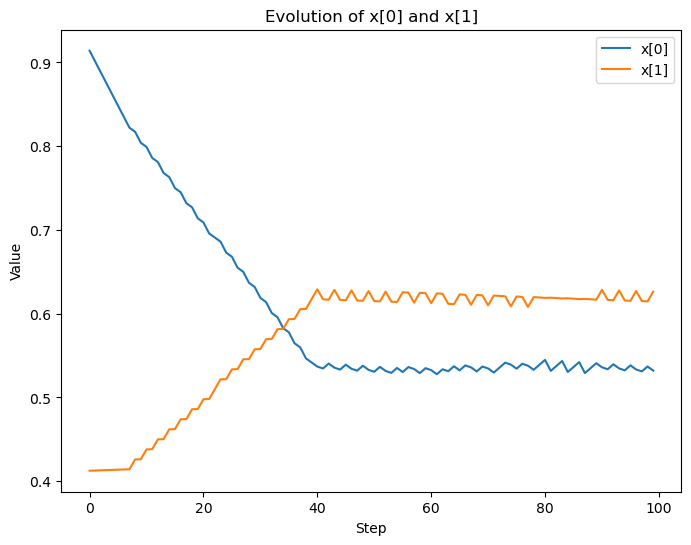

In [17]:
# Plotting the evolution of x[0] and x[1]
plt.figure(figsize=(8, 6))
plt.plot(x0_values, label='x[0]')
plt.plot(x1_values, label='x[1]')
plt.xlabel('Step')
plt.ylabel('Value')
plt.title('Evolution of x[0] and x[1]')
plt.legend()
plt.show()

In [21]:
# define the de-normalization function
def de_normalize_tensor(tensor, max_val, min_val):
    return tensor * (max_val - min_val) + min_val
    
# de-normalize the porosity of anode and cathode
value_real0 = de_normalize_tensor(x[0], max_epsneg, min_epsneg)
print(value_real0)    # optimized result of anode porosity
value_real1 = de_normalize_tensor(x[1], max_epspos, min_epspos)
print(value_real1)    # optimized result of cathode porosity

# de-normalize the capacity value (C/m^2)
y = model(x)
cap_optim = de_normalize_tensor(y[0], max_y, min_y)
print(cap_optim)

tensor(0.4895, grad_fn=<AddBackward0>)
tensor(0.5342, grad_fn=<AddBackward0>)
tensor(24.2964, grad_fn=<AddBackward0>)
